# Scenario 3: Causal Reasoning with Interventions

### Load dependencies

In [1]:
import os
import json
import sympy
import pandas as pd
import pyciemss
import torch
import pyro
import pyro.distributions as dist

import pyciemss.visuals.plots as plots
import pyciemss.visuals.vega as vega
import pyciemss.visuals.trajectories as trajectories

from mira.metamodel import *
from mira.examples.concepts import susceptible, exposed, infected, recovered
from mira.modeling import Model
from mira.modeling.amr.petrinet import AMRPetriNetModel, template_model_to_petrinet_json
from mira.metamodel.io import model_to_json_file, model_from_json_file
from pathlib import Path

## Build SEIR model

In [ ]:
# Define units
person_units = lambda: Unit(expression=sympy.Symbol('person'))
day_units = lambda: Unit(expression=sympy.Symbol('day'))
per_day_units = lambda: Unit(expression=1/sympy.Symbol('day'))
dimensionless_units = lambda: Unit(expression=sympy.Integer('1'))
per_day_per_person_units = lambda: Unit(expression=1/(sympy.Symbol('day')*sympy.Symbol('person')))

In [ ]:
# Define and stratify concepts
_susceptible = Concept(name='S', units=person_units(), identifiers={'ido': '0000514'})
_exposed = Concept(name='E', units=person_units(), identifiers={'apollosv': '00000154'})
_infected = Concept(name='I', units=person_units(), identifiers={'ido': '0000511'})
_recovered = Concept(name='R', units=person_units(), identifiers={'ido': '0000592'})

c = {
    'S_y': _susceptible.with_context(status="young"),
    'S_m': _susceptible.with_context(status="middle"),
    'S_o': _susceptible.with_context(status="young"),
    'E_y': _exposed.with_context(status="young"),
    'E_m': _exposed.with_context(status="middle"),
    'E_o': _exposed.with_context(status="old"),
    'I_y': _infected.with_context(status="young"),
    'I_m': _infected.with_context(status="middle"),
    'I_o': _infected.with_context(status="old"),
    'R_y': _recovered.with_context(status="young"),
    'R_m': _recovered.with_context(status="middle"),
    'R_o': _recovered.with_context(status="old"),
}
c['S_y'].name = 'S_y'
c['S_m'].name = 'S_m'
c['S_o'].name = 'S_o'
c['E_y'].name = 'E_y'
c['E_m'].name = 'E_m'
c['E_o'].name = 'E_o'
c['I_y'].name = 'I_y'
c['I_m'].name = 'I_m'
c['I_o'].name = 'I_o'
c['R_y'].name = 'R_y'
c['R_m'].name = 'R_m'
c['R_o'].name = 'R_o'

In [ ]:
# Define parameters
parameters = {
    'beta': Parameter(name='beta', value=sympy.Float(0.2), units=per_day_units()),  # Infection rate
    'N': Parameter(name='total_population', value=sympy.Float(37742307.0), units=per_day_units()),  # Total population
    'mew': Parameter(name='mew', value=sympy.Float(0.0), units=per_day_units()),  # Mask efficacy
    'mcw': Parameter(name='mcw', value=sympy.Float(0.0), units=per_day_units()),  # Mask compliance
    'r_EI': Parameter(name='r_EI', value=sympy.Float(0.08), units=per_day_units()),  # Rate of progressing E -> I
    'r_IR': Parameter(name='r_IR', value=sympy.Float(0.06), units=per_day_units()),  # Rate of progressing I -> R
    'Myy': Parameter(name='Myy', value=sympy.Float(38.62), units=per_day_units()),  # Contact rate young -> young
    'Mym': Parameter(name='Mym', value=sympy.Float(20.56), units=per_day_units()),  # Contact rate young -> middle
    'Myo': Parameter(name='Myo', value=sympy.Float(6.12), units=per_day_units()),  # Contact rate young -> old
    'Mmy': Parameter(name='Mmy', value=sympy.Float(20.56), units=per_day_units()),  # Contact rate middle -> young
    'Mmm': Parameter(name='Mmm', value=sympy.Float(28.22), units=per_day_units()),  # Contact rate middle -> middle
    'Mmo': Parameter(name='Mmo', value=sympy.Float(11.6), units=per_day_units()),  # Contact rate middle -> old
    'Moy': Parameter(name='Moy', value=sympy.Float(6.12), units=per_day_units()),  # Contact rate old -> young
    'Mom': Parameter(name='Mom', value=sympy.Float(11.6), units=per_day_units()),  # Contact rate old -> middle
    'Moo': Parameter(name='Moo', value=sympy.Float(20.01), units=per_day_units()),  # Contact rate old -> old
}

In [ ]:
# Define variables
S_y, S_m, S_o, E_y, E_m, E_o, I_y, I_m, I_o, R_y, R_m, R_o, beta, N, mew, mcw, r_EI, r_IR, Myy, Mym, Myo, Mmy, Mmm, Mmo, Moy, Mom, Moo = \
    sympy.symbols(
        'S_y S_m S_o E_y E_m E_o I_y I_m I_o R_y R_m R_o beta N mew mcw r_EI r_IR Myy Mym Myo Mmy Mmm Mmo Moy Mom Moo'
    )

In [ ]:
# Set initial values
initials = {
    "S_y": Initial(concept=Concept(name="S_y"), expression=sympy.Float(10305660.0)),
    "S_m": Initial(concept=Concept(name="S_m"), expression=sympy.Float(15281905.0)),
    "S_o": Initial(concept=Concept(name="S_o"), expression=sympy.Float(12154442.0)),
    "E_y": Initial(concept=Concept(name="E_y"), expression=sympy.Float(50.0)),
    "E_m": Initial(concept=Concept(name="E_m"), expression=sympy.Float(50.0)),
    "E_o": Initial(concept=Concept(name="E_o"), expression=sympy.Float(50.0)),
    "I_y": Initial(concept=Concept(name="I_y"), expression=sympy.Float(50.0)),
    "I_m": Initial(concept=Concept(name="I_m"), expression=sympy.Float(50.0)),
    "I_o": Initial(concept=Concept(name="I_o"), expression=sympy.Float(50.0)),
    "R_y": Initial(concept=Concept(name="R_y"), expression=sympy.Float(0.0)),
    "R_m": Initial(concept=Concept(name="R_m"), expression=sympy.Float(0.0)),
    "R_o": Initial(concept=Concept(name="R_o"), expression=sympy.Float(0.0)),
}

In [ ]:
# Define templates
##### S -> E
# Sy -> Ey by Iy
syeyiy = ControlledConversion(
    subject=c['S_y'],
    outcome=c['E_y'],
    controller=c['I_y'],
    rate_law=beta*S_y*(1 - mew*mcw)*(Myy*I_y) / N
)
# Sy -> Ey by Im
syeyim = ControlledConversion(
    subject=c['S_y'],
    outcome=c['E_y'],
    controller=c['I_m'],
    rate_law=beta*S_y*(1 - mew*mcw)*(Mym*I_m) / N
)
# Sy -> Ey by Io
syeyio = ControlledConversion(
    subject=c['S_y'],
    outcome=c['E_y'],
    controller=c['I_o'],
    rate_law=beta*S_y*(1 - mew*mcw)*(Myo*I_o) / N
)

# Sm -> Em by Iy
smemiy = ControlledConversion(
    subject=c['S_m'],
    outcome=c['E_m'],
    controller=c['I_y'],
    rate_law=beta*S_m*(1 - mew*mcw)*(Mmy*I_y) / N
)
# Sm -> Em by Im
smemim = ControlledConversion(
    subject=c['S_m'],
    outcome=c['E_m'],
    controller=c['I_m'],
    rate_law=beta*S_m*(1 - mew*mcw)*(Mmm*I_m) / N
)
# Sm -> Em by Io
smemio = ControlledConversion(
    subject=c['S_m'],
    outcome=c['E_m'],
    controller=c['I_o'],
    rate_law=beta*S_m*(1 - mew*mcw)*(Mmo*I_o) / N
)

# So -> Eo by Iy
soeoiy = ControlledConversion(
    subject=c['S_o'],
    outcome=c['E_o'],
    controller=c['I_y'],
    rate_law=beta*S_o*(1 - mew*mcw)*(Moy*I_y) / N
)
# So -> Eo by Im
soeoim = ControlledConversion(
    subject=c['S_o'],
    outcome=c['E_o'],
    controller=c['I_m'],
    rate_law=beta*S_o*(1 - mew*mcw)*(Mom*I_m) / N
)
# So -> Eo by Io
soeoio = ControlledConversion(
    subject=c['S_o'],
    outcome=c['E_o'],
    controller=c['I_o'],
    rate_law=beta*S_o*(1 - mew*mcw)*(Moo*I_o) / N
)

#### E -> I
# Ey -> Iy
eyiy = NaturalConversion(
    subject=c['E_y'],
    outcome=c['I_y'],
    rate_law=r_EI*E_y
)
# Em -> Im
emim = NaturalConversion(
    subject=c['E_m'],
    outcome=c['I_m'],
    rate_law=r_EI*E_m
)
# Eo -> Io
eoio = NaturalConversion(
    subject=c['E_o'],
    outcome=c['I_o'],
    rate_law=r_EI*E_o
)

#### I -> R
# Iy -> Ry
iyry = NaturalConversion(
    subject=c['I_y'],
    outcome=c['R_y'],
    rate_law=r_IR*I_y
)
# Im -> Rm
imrm = NaturalConversion(
    subject=c['I_m'],
    outcome=c['R_m'],
    rate_law=r_IR*I_m
)
# Io -> Ro
ioro = NaturalConversion(
    subject=c['I_o'],
    outcome=c['R_o'],
    rate_law=r_IR*I_o
)

In [ ]:
# Define template model
seir_model = TemplateModel(
    templates=[
        syeyiy,
        syeyim,
        syeyio,
        smemiy,
        smemim,
        smemio,
        soeoiy,
        soeoim,
        soeoio,
        eyiy,
        emim,
        eoio,
        iyry,
        imrm,
        ioro,
    ],
    parameters=parameters,
    initials=initials,
    time=Time(name='t', units=day_units()),
    annotations=Annotations(name='EPI EVAL Scenario 3')
)

# Save as JSON
with open("SEIR_model.json", 'w') as fh:
    json.dump(template_model_to_petrinet_json(seir_model), fh, indent=1)

# NOTE! Parameter distributions and observables added by HAND

## Simulate SEIR model

,timepoint_id,sample_id,timepoint_unknown,persistent_beta_param,E_m_state,E_o_state,E_y_state,I_m_state,I_o_state,I_y_state,R_m_state,R_o_state,R_y_state,S_m_state,S_o_state,S_y_state,susceptible_observable_state,exposed_observable_state,infected_observable_state,recovered_observable_state
0,0,0,10.0,0.446734,7.165400e+05,2.938192e+05,5.128787e+05,7.110924e+04,2.918366e+04,5.093857e+04,5.650433e+03,2.355114e+03,4.056836e+03,1.448870e+07,1.182919e+07,9.737887e+06,3.605577e+07,1523237.75,1.512315e+05,1.206238e+04
1,1,0,20.0,0.446734,9.056928e+06,7.850493e+06,6.064386e+06,4.979768e+06,3.536018e+06,3.383880e+06,1.245232e+06,7.553572e+05,8.574526e+05,8.174133e+01,1.266620e+04,3.858869e+01,1.278653e+04,22971806.00,1.189967e+07,2.858042e+06
2,2,0,30.0,0.446734,4.069576e+06,3.533405e+06,2.724921e+06,6.337014e+06,5.069504e+06,4.270334e+06,4.875412e+06,3.551632e+06,3.310504e+06,1.085363e-14,2.599229e-06,4.066695e-15,2.599229e-06,10327902.00,1.567685e+07,1.173755e+07
3,3,0,40.0,0.446734,1.828578e+06,1.587661e+06,1.224386e+06,5.097238e+06,4.188254e+06,3.427938e+06,8.356190e+06,6.378624e+06,5.653431e+06,4.824406e-30,7.596275e-16,1.751943e-30,7.596275e-16,4640624.00,1.271343e+07,2.038825e+07
4,4,0,50.0,0.446734,8.216342e+05,7.133821e+05,5.501519e+05,3.525070e+06,2.930342e+06,2.368513e+06,1.093531e+07,8.510821e+06,7.387087e+06,4.744800e-38,5.663190e-23,4.625295e-38,5.663190e-23,2085168.25,8.823925e+06,2.683322e+07


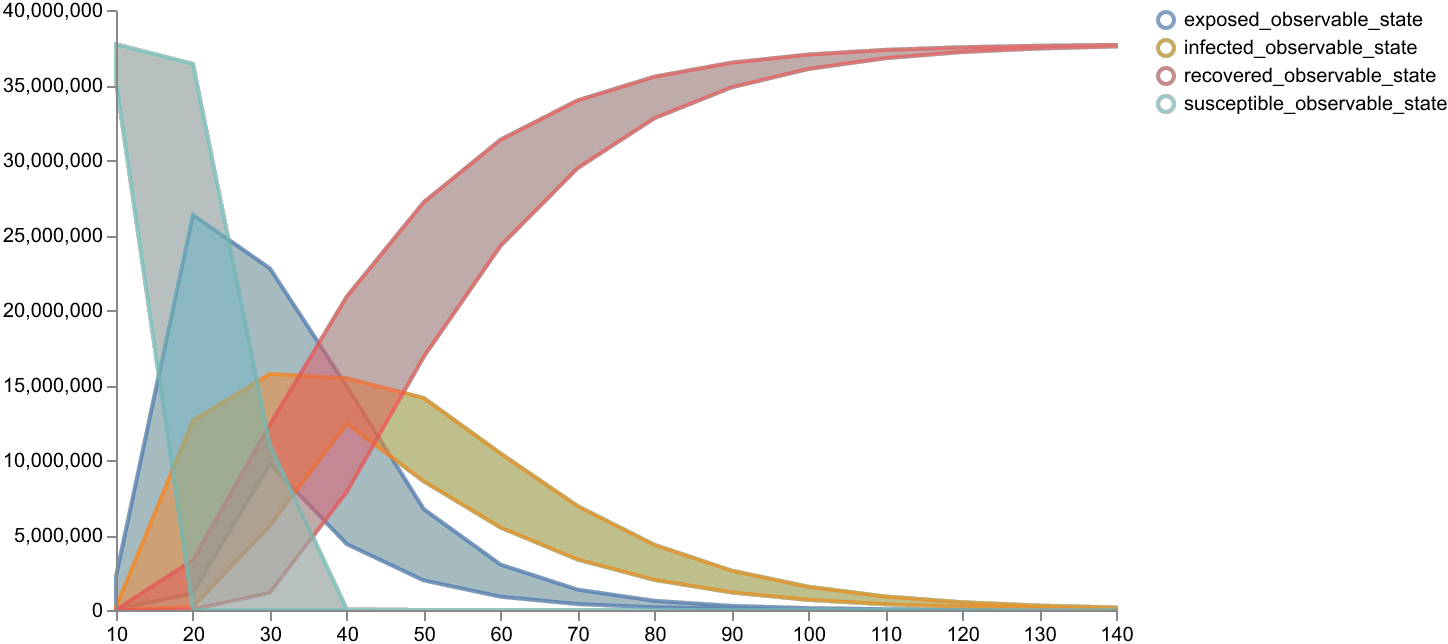

In [2]:
model1 = "SEIR_model.json"
start_time = 0.0
end_time = 150.0
logging_step_size = 10.0
num_samples = 50

result1 = pyciemss.sample(model1, end_time, logging_step_size, num_samples, start_time=start_time)
display(result1['data'].head())

# Plot results for all states
schema = plots.trajectories(result1["data"], keep=".*observable_state")
plots.save_schema(schema, "_schema.json")
plots.ipy_display(schema, dpi=150)

## Define interventions at `t = 20, 50, 80, 100`

In [5]:
social_dist = [0.3, 0.8]
intervention_dict = {torch.tensor(20.0): {"Myy": torch.tensor(social_dist[0]*38.62), 
                                          "Mym": torch.tensor(social_dist[0]*20.56),
                                          "Myo": torch.tensor(social_dist[0]*6.12),
                                          "Mmy": torch.tensor(social_dist[0]*20.56),
                                          "Mmm": torch.tensor(social_dist[0]*28.22),
                                          "Mmo": torch.tensor(social_dist[0]*11.6),
                                          "Moy": torch.tensor(social_dist[0]*6.12),
                                          "Mom": torch.tensor(social_dist[0]*11.6),
                                          "Moo": torch.tensor(social_dist[0]*20.01)
                                         },
                     torch.tensor(50.0): {"mcw": torch.tensor(0.5), 
                                          "mew": torch.tensor(0.6)
                                         },
                     # torch.tensor(80.0): {"Myy": torch.tensor(social_dist[1]*38.62), 
                     #                      "Mym": torch.tensor(social_dist[1]*20.56),
                     #                      "Myo": torch.tensor(social_dist[1]*6.12),
                     #                      "Mmy": torch.tensor(social_dist[1]*20.56),
                     #                      "Mmm": torch.tensor(social_dist[1]*28.22),
                     #                      "Mmo": torch.tensor(social_dist[1]*11.6),
                     #                      "Moy": torch.tensor(social_dist[1]*6.12),
                     #                      "Mom": torch.tensor(social_dist[1]*11.6),
                     #                      "Moo": torch.tensor(social_dist[1]*20.01)
                     #                     },
                     # torch.tensor(100.0): {"mcw": torch.tensor(0.4), 
                     #                      "mew": torch.tensor(0.2)
                     #                     }
                    }
intervention_dict

{tensor(20.): {'Myy': tensor(11.5860),
  'Mym': tensor(6.1680),
  'Myo': tensor(1.8360),
  'Mmy': tensor(6.1680),
  'Mmm': tensor(8.4660),
  'Mmo': tensor(3.4800),
  'Moy': tensor(1.8360),
  'Mom': tensor(3.4800),
  'Moo': tensor(6.0030)},
 tensor(50.): {'mcw': tensor(0.5000), 'mew': tensor(0.6000)}}

In [11]:
result = pyciemss.sample(model1, end_time, logging_step_size, num_samples, start_time=start_time, 
                         static_parameter_interventions={torch.tensor(20.0): {'Myo': torch.tensor(11.5860)}})
display(result["data"].head())

# Plot the result
schema = plots.trajectories(pd.DataFrame(result["data"]), keep=".*_state")
plots.save_schema(schema, "_schema.json")
plots.ipy_display(schema, dpi=150)

ERROR:root:
                ###############################

                There was an exception in pyciemss

                Error occured in function: sample

                Function docs : 
    Load a model from a file, compile it into a probabilistic program, and sample from it.

    Args:
        model_path_or_json: Union[str, Dict]
            - A path to a AMR model file or JSON containing a model in AMR form.
        end_time: float
            - The end time of the sampled simulation.
        logging_step_size: float
            - The step size to use for logging the trajectory.
        num_samples: int
            - The number of samples to draw from the model.
        solver_method: str
            - The method to use for solving the ODE. See torchdiffeq's `odeint` method for more details.
            - If performance is incredibly slow, we suggest using `euler` to debug.
              If using `euler` results in faster simulation, the issue is likely that the model is s

KeyError: "No target column match found for 'Myo'."

## Load and plot data

In [ ]:
dataset = pd.read_csv("./Scenario 3 Supplementary/S3SimulationRuns.csv")
run_n = dataset[dataset.run==1].drop(['run',
                                      'R1','R2','R3',
                                      'S1','S2','S3',
                                      'E1','E2','E3'], axis=1)
y = ["_y","_m","_o"]
x = {"time":"Timestamp"}
x|= {"S"+str(i+1):"S"+y[i] for i in range(3)}
x|= {"E"+str(i+1):"E"+y[i] for i in range(3)}
x|= {"I"+str(i+1):"I"+y[i] for i in range(3)}
x|= {"R"+str(i+1):"R"+y[i] for i in range(3)}
run_n = run_n.rename(columns=x)
run_n['I_sum'] = run_n.apply(lambda row: row.I_y+row.I_m+row.I_o, axis=1)

## Recreate the Scenario Figure (mostly)
agegroup = "1"
import seaborn as sns
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
sns.lineplot(data=dataset.pivot(index="time", columns="run", values="S"+agegroup),
             palette='Greys', alpha=.7, ax=ax)
sns.lineplot(data=dataset.pivot(index="time", columns="run", values="E"+agegroup),
             palette='Greens', alpha=.7, ax=ax)
sns.lineplot(data=dataset.pivot(index="time", columns="run", values="I"+agegroup),
             palette='Blues', alpha=.7, ax=ax)
sns.lineplot(data=dataset.pivot(index="time", columns="run", values="R"+agegroup),
             palette='YlOrBr', alpha=.7, ax=ax)
ax.get_legend().remove()

## Calibrate the model 

In [ ]:
num_iterations = 100

# data_mapping = {"I_y": "I_y","I_m":"I_m","I_o":"I_o"}
data_mapping = {"I_sum": "infected"}
%time calibrated_results = pyciemss.calibrate(model1, run_n, data_mapping=data_mapping, num_iterations=num_iterations)

parameter_estimates = calibrated_results["inferred_parameters"]
parameter_estimates()